In [79]:
import numpy as np
import pickle
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from src.utils import ExpLoss, levenshtein_distance
from ru_soundex.soundex import RussianSoundex

In [4]:
from src.parse_assessment import parse_assessment
pd.set_option('display.max_columns', 100, 'display.max_rows', 100)

df = parse_assessment('data/Assessmen(0.125, var)t.xlsx')
keyword_columns = df.columns[df.columns.str.contains('keywords') & (df.notna().sum() > 100)]

with open('datasets/raw_text_dataset.pickle', 'rb') as f:
    text_df = pickle.load(f)
text_df['full_text'] = text_df['task1_text'] + " " + text_df['task2_text'] + " " + text_df['task3_text']
df = pd.merge(df, text_df, on='email')
df = df.loc[::2]

In [89]:
train_df = df[['мотивация keywords', 'full_text']].dropna()
train_df.rename(columns={'мотивация keywords': 'keywords', 'full_text': 'text'}, inplace=True)
train_df = train_df[train_df.text.apply(type) == str]
train_df = train_df[train_df.keywords.apply(lambda keyword: type(keyword) == str)]
train_df['text_tokens'] = train_df.text.str.split(" ")
train_df['target_tokens'] = train_df.keywords.str.split(" ")
train_df['target_tokens'] = train_df['target_tokens'].map(lambda tokens: list(map(lambda token: re.sub(r'[^\w\s]', '', token), tokens)))
train_df = train_df[train_df.text_tokens.apply(lambda tokens: len(tokens) > 200)]
train_df.reset_index(inplace=True)

In [90]:
from ru_soundex.soundex import RussianSoundex

def find_subsequence(seq_tokens, subseq_tokens):

    subseq_text = " ".join(subseq_tokens)
    seq_text = " ".join(seq_tokens)

    soundex = RussianSoundex()
    subseq_soundex = soundex.transform(subseq_text)
    seq_soundex = soundex.transform(seq_text)
    
    char2word = [None for _ in seq_soundex]
    current_word = 0
    for i in range(len(seq_soundex)):
        char2word[i] = current_word
        if seq_soundex[i] == " ":
            current_word += 1

    left_char, right_char, distance = levenshtein_distance(seq_soundex, subseq_soundex)
    
    return char2word[left_char], char2word[right_char], distance

In [108]:
pos = 21

left_word, right_word, distance = find_subsequence(train_df.loc[pos].text_tokens, train_df.loc[pos].target_tokens)
print(train_df.loc[pos].text_tokens[left_word:right_word+1])
print(train_df.loc[pos].target_tokens)
print(left_word, right_word)
print(distance)

['информационные', 'технологии', 'и', 'повысить', 'уровень', 'организации', 'образовательного', 'процесса', 'оказать', 'помощь', 'взаимодействие', 'обучающимися', 'системе', 'он-лайн', 'проведения', 'различных', 'конференций', 'использования', 'онлайн', 'лекции']
['интересно', 'изучение', 'географических', 'информационных', 'систем\nдаст', 'возможность', 'соврешенно', 'подругому', 'проработать', 'и', 'подать', 'преподаваемую', 'дисциплину', 'с', 'учетом', 'современных', 'требований', 'с', 'учето', 'соврешенно', 'новых', 'возможностей', 'котореы', 'открываются', 'с', 'использованием', 'новых', 'иттехнологий']
26 45
130


In [125]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("rubert")

OSError: Can't load config for 'rubert'. Make sure that:

- 'rubert' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'rubert' is the correct path to a directory containing a config.json file



In [124]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [123]:
len(tokenizer.encode(train_df.loc[22].text))

353

In [5]:
from torch.utils.data import IterableDataset

class NegativeSamplingDataset(IterableDataset):
    
    def __init__(self, targets, texts, negative_sampling_ratio=10):
        self.targets = targets
        self.texts = texts
        self.ns_ratio = negative_sampling_ratio
        
        target_lengths = list(map(len, targets))
        self.min_length = max(min(target_lengths), 8)
        self.max_length = max(target_lengths)
        
    def __len__(self):
        return len(self.targets)
    
    def __iter__(self):
        np.random.shuffle(self.targets)
        
        for positive_token in self.targets:
            text = np.random.choice(self.texts)
            start_indexes = np.random.randint(len(text) - self.max_length, size=self.ns_ratio)
            lengths = np.random.randint(self.min_length, self.max_length, size=self.ns_ratio)
            negative_tokens = [text[index: index+length] for index, length in zip(start_indexes, lengths)]
            
            yield positive_token, negative_tokens

In [6]:
from navec import Navec
import torch
from torch import nn

class Classifier1(nn.Module):
    def __init__(self, embedding, classes):
        super().__init__()
        self.layer = nn.Linear(embedding, classes)
    
    def forward(self, vector):
        X = self.layer(vector)
        return X[:, 0]
    
    def predict(self, vector):
        scores = self.forward(vector)
        return scores > 0

In [7]:
class Classifier2(nn.Module):
    def __init__(self, embedding, classes):
        super().__init__()
        self.layer1 = nn.Linear(embedding, 100)
        self.activation1 = nn.Sigmoid()
        self.layer2 = nn.Linear(100, classes)
    
    def forward(self, vector):
        X = self.layer1(vector)
        X = self.activation1(X)
        X = self.layer2(X)
        return X[:, 0]
    
    def predict(self, vector):
        scores = self.forward(vector)
        return scores > 0

In [8]:
from sklearn.metrics import accuracy_score

def test(dataset):
    preds = []
    targets = []
    for pos_sample, neg_samples in dataset:
        pos_vector = torch.FloatTensor([embedder.get(word) for word in pos_sample if word in embedder]).mean(axis=0, keepdims=True)
        neg_vectors = torch.from_numpy(np.concatenate([np.array([embedder.get(word) for word in sample if word in embedder]).mean(axis=0, keepdims=True) for sample in neg_samples]))
        pos_output = classifier.predict(pos_vector)
        neg_output = classifier.predict(neg_vectors)
        preds.append(pos_output.item())
        targets.append(True)
        preds.extend([out.item() for out in neg_output])
        targets.extend([False for _ in neg_output])
    return accuracy_score(preds, targets)

In [9]:
epochs = 25
ns_ratio = 25

classifier = Classifier2(300, 1)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
train_dataset = NegativeSamplingDataset(train_df['target_tokens'][:-200], train_df['text_tokens'][:-200], negative_sampling_ratio=ns_ratio)
test_dataset  = NegativeSamplingDataset(train_df['target_tokens'][-200:].to_list(), train_df['text_tokens'][-200:].to_list(), negative_sampling_ratio=ns_ratio)
embedder = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')
pos_loss_f = nn.BCEWithLogitsLoss(weight=torch.FloatTensor([1]))
neg_loss_f = nn.BCEWithLogitsLoss(weight=torch.FloatTensor([1/ns_ratio]))

train_accuracies = []
test_accuracies = []
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}", flush=True)
    t = tqdm(train_dataset)
    exp_loss = ExpLoss()
    for pos_sample, neg_samples in t:
        pos_vector = torch.FloatTensor([embedder.get(word) for word in pos_sample if word in embedder]).mean(axis=0, keepdims=True)
        neg_vectors = torch.from_numpy(np.concatenate([np.array([embedder.get(word) for word in sample if word in embedder]).mean(axis=0, keepdims=True) for sample in neg_samples]))
        pos_output = classifier(pos_vector)
        neg_output = classifier(neg_vectors)
        loss = pos_loss_f(pos_output, torch.ones(1)) + pos_loss_f(neg_output, torch.zeros(ns_ratio))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t.set_postfix(loss=exp_loss(loss.item()))
    train_accuracies.append(test(train_dataset))
    test_accuracies.append(test(test_dataset))

Epoch: 1


  3%|▎         | 24/831 [00:00<00:26, 30.62it/s, loss=1.38]


KeyboardInterrupt: 

In [12]:
def generate_data(dataset):
    x = []
    y = []
    for pos_sample, neg_samples in dataset:
        pos_vector = np.array([embedder.get(word) for word in pos_sample if word in embedder]).mean(axis=0)
        neg_vectors = np.concatenate([np.array([embedder.get(word) for word in sample if word in embedder]).mean(axis=0, keepdims=True) for sample in neg_samples])
        x.append(pos_vector)
        y.append(1)
        x.extend(neg_vectors)
        y.extend([0 for _ in neg_vectors])
    return np.array(x), np.array(y)

x, y = generate_data(train_dataset)

In [46]:
from catboost import CatBoostClassifier

classifier = CatBoostClassifier()
classifier.fit(x, y)

Learning rate set to 0.038265
0:	learn: 0.6266930	total: 258ms	remaining: 4m 17s
1:	learn: 0.5728501	total: 386ms	remaining: 3m 12s
2:	learn: 0.5257415	total: 511ms	remaining: 2m 49s
3:	learn: 0.4802180	total: 618ms	remaining: 2m 34s
4:	learn: 0.4379112	total: 724ms	remaining: 2m 24s
5:	learn: 0.4012831	total: 810ms	remaining: 2m 14s
6:	learn: 0.3656308	total: 914ms	remaining: 2m 9s
7:	learn: 0.3379568	total: 1.03s	remaining: 2m 7s
8:	learn: 0.3121359	total: 1.13s	remaining: 2m 4s
9:	learn: 0.2884268	total: 1.27s	remaining: 2m 5s
10:	learn: 0.2691827	total: 1.4s	remaining: 2m 5s
11:	learn: 0.2513719	total: 1.51s	remaining: 2m 4s
12:	learn: 0.2341514	total: 1.63s	remaining: 2m 3s
13:	learn: 0.2187807	total: 1.73s	remaining: 2m 1s
14:	learn: 0.2048046	total: 1.81s	remaining: 1m 59s
15:	learn: 0.1916371	total: 1.9s	remaining: 1m 56s
16:	learn: 0.1820068	total: 1.98s	remaining: 1m 54s
17:	learn: 0.1733973	total: 2.07s	remaining: 1m 53s
18:	learn: 0.1649761	total: 2.16s	remaining: 1m 51s
19

In [47]:
accuracy_score(y, classifier.predict(x))

0.9999074331204295

In [15]:
x_test, y_test = generate_data(test_dataset)

/home/akkyma/anaconda3/envs/vosk/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [48]:
accuracy_score(y_test, classifier.predict(x_test))

0.9665384615384616

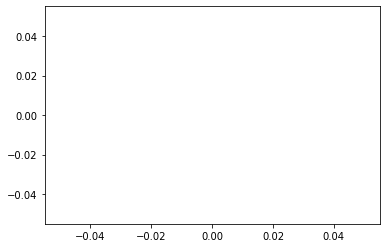

In [10]:
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies)
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies)

In [49]:
def detect_motivation(tokens, min_window=5, max_window=30):
    max_window = min(len(tokens), max_window)
    max_score = -np.float('inf')
    max_start_index, max_end_index = None, None
    for window_size in range(min_window, max_window+1):
        for start_token_index in range(0, len(tokens) - window_size):
            end_token_index = start_token_index + window_size
            current_tokens = tokens[start_token_index: end_token_index]
            vector = torch.FloatTensor([embedder.get(word) for word in current_tokens if word in embedder]).mean(axis=0, keepdims=True)
            score = classifier.forward(vector).item()
            if score > max_score:
                max_score = score
                max_start_index = start_token_index
                max_end_index = end_token_index
    return tokens[max_start_index: max_end_index], score

In [50]:
def detect_motivation(tokens, min_window=5, max_window=30):
    max_window = min(len(tokens), max_window)
    max_score = -np.float('inf')
    max_start_index, max_end_index = None, None
    for window_size in range(min_window, max_window+1):
        for start_token_index in range(0, len(tokens) - window_size):
            end_token_index = start_token_index + window_size
            current_tokens = tokens[start_token_index: end_token_index]
            vector = np.array([embedder.get(word) for word in current_tokens if word in embedder]).mean(axis=0, keepdims=True)
            score = classifier.predict_proba(vector)[0, 1]
            if score > max_score:
                max_score = score
                max_start_index = start_token_index
                max_end_index = end_token_index
    return tokens[max_start_index: max_end_index], score

In [49]:
def check_motivation(index):
    print(" ".join(train_df.text_tokens[index]))
    print()
    print(" ".join(train_df.target_tokens[index]))
    print()
    print(detect_motivation(train_df.text_tokens[index]))

In [51]:
import multiprocessing as mp

def multiple_detect_motivation(corpus, workers=1):
    def worker():
        while True:
            index, tokens = command_queue.get()
            result = detect_motivation(tokens)
            result_queue.put((index, result))
    
    command_queue = mp.Queue()
    result_queue = mp.Queue()
    processes = [mp.Process(target=worker) for _ in range(workers)]
    result_list = [None for _ in corpus]
    
    for index, tokens in enumerate(corpus):
        command_queue.put((index, tokens))
        
    for process in processes:
        process.start()
        
    for _ in corpus:
        index, result = result_queue.get()
        result_list[index] = result
        
    for process in processes:
        process.terminate()
        
    return result_list

In [52]:
results = multiple_detect_motivation(train_df.text_tokens[-50:], workers=1)

In [29]:
index = 6

print(" ".join(train_df.text_tokens[-50:][981+index]))
print()
print(" ".join(train_df.target_tokens[-50:][981+index]))

здравствуйте уважаемые организаторы меня зовут ощупывающий билли но ричард мне двадцать девять лет хочу сказать что студент меняется студент хороший но он просто сейчас другой и зачастую о том как меняется информационное пространство и обыкновенны от студентов и начинаю немного отставать и для того чтобы быть интересным для своего студента нужно идти с ним в ногу со временем и даже его немного опережать именно для этого я в этом проекте я хочу чтобы мой предмет и я лично со своим знанием была интересна на любом курсе на любой специальности это даёт для меня возможность интереснее преподнести свой присылайте всех процессов и производств и пятна со стороны всеми средствами автоматизации делает то что необходимо первое мышцы полностью перенастроить дистанционные курсы проведения лабораторных и про очень удобно проводить проводить наложить на различных платформах в виде видел видеоконференции и необходимо уметь как представлять материал так и уши то работа с материалом который представляет

In [53]:
for phrase, score in results:
    print(score)
    print(" ".join(phrase))

0.0005113494339963526
дать им эти новые компетенции
0.0037912877178355926
использовать ну можно начать с
0.01242825906825994
проанализировать задачи внедрения цифровых технологий
0.9044672330827026
позволит мне расширить свои знания о
0.9044672330827026
позволит мне расширить свои знания о
0.003964397310782931
нужно идти с ним в
0.003964397310782931
нужно идти с ним в
0.0031940810979304525
позволяет создавать базу данных и хранить информацию о достижениях
0.0031940810979304525
позволяет создавать базу данных и хранить информацию о достижениях
0.09701059337751694
повышения уровня знаний специалистов о пойти технологиях
0.09701059337751694
повышения уровня знаний специалистов о пойти технологиях
0.00024638027163657514
необходимо будет в дальнейшем переходить
0.00024638027163657514
необходимо будет в дальнейшем переходить
0.004690788103299196
будем использовать для решения задач
0.004690788103299196
будем использовать для решения задач
0.022466949641040422
приложений позволяющих самостоят